# Feature selection using regression methods

The idea is to use penalizing methods - *elastic net*, *lasso* - to perform feature selection

## Import packages

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

Add parent directory as path

In [2]:
import sys

In [3]:
sys.path.append('..')

In [4]:
raw_df = pd.read_csv("../data/dataset.csv", index_col=0, parse_dates=[0])
raw_df.head()

,VIX,T10Y3M,BAA10Y,DGS10,DCOILWTICO,DTWEXBGS,USEPUINDXD,WLEMUINDXD,BAMLC0A4CBBB,BAMLC0A1CAAA,...,MOM_5,MOM_10,RSI_5,RSI_10,BOLUP_5,BOLDOWN_5,BOLUP_10,BOLDOWN_10,ADX_5,ADX_10
2003-01-02,25.39,2.85,3.37,4.07,69.05,100.8803,324.67,188.18,2.67,1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-03,24.68,2.83,3.39,4.05,70.34,100.4474,357.74,148.90,2.64,1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-06,24.91,2.88,3.38,4.09,69.37,99.9413,166.02,295.76,2.61,0.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-07,25.13,2.85,3.39,4.04,68.28,100.3036,180.02,248.74,2.58,0.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-08,25.53,2.81,3.35,4.00,67.74,100.1151,204.91,81.20,2.57,0.96,...,NaN,NaN,NaN,NaN,25.819722,24.436278,NaN,NaN,NaN,NaN


Check for Nans

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VIX                     5217 non-null   float64
 1   T10Y3M                  5217 non-null   float64
 2   BAA10Y                  5217 non-null   float64
 3   DGS10                   5217 non-null   float64
 4   DCOILWTICO              5217 non-null   float64
 5   DTWEXBGS                5217 non-null   float64
 6   USEPUINDXD              5217 non-null   float64
 7   WLEMUINDXD              5217 non-null   float64
 8   BAMLC0A4CBBB            5217 non-null   float64
 9   BAMLC0A1CAAA            5217 non-null   float64
 10  BAMLC0A4CBBBEY          5217 non-null   float64
 11  BAMLC0A1CAAAEY          5217 non-null   float64
 12  BAMLC0A0CM              5217 non-null   float64
 13  BAMLC0A0CMEY            5217 non-null   float64
 14  DFII5                 

Some of the data is returns, thus should drop first day and untransformed data

In [5]:
# Set first day to 1 + first day
df = raw_df.iloc[10:].copy()
del raw_df
df.drop(columns=["DCOILWTICO", "DTWEXBGS", "Gold"], inplace=True)

**OPTIONAL**: Change to *Business Day* frequency. Should not introduce any NaNs in index, as demonstrated below

In [7]:
(df.asfreq("B").index == df.index).all()

True

## Create train/val/test split

In [44]:
n = len(df)
train_ind = int(n*0.7)
val_ind = int(n*0.9)

train_df = df[:train_ind]
val_df = df[train_ind:val_ind]
test_df = df[val_ind:]

## Plot periods to check for differences

This plot plots the entire dataset, training, validation and test on a shared x and y axis. This allows for comparing differences quite easily

Text(0.5, 1.0, 'Test')

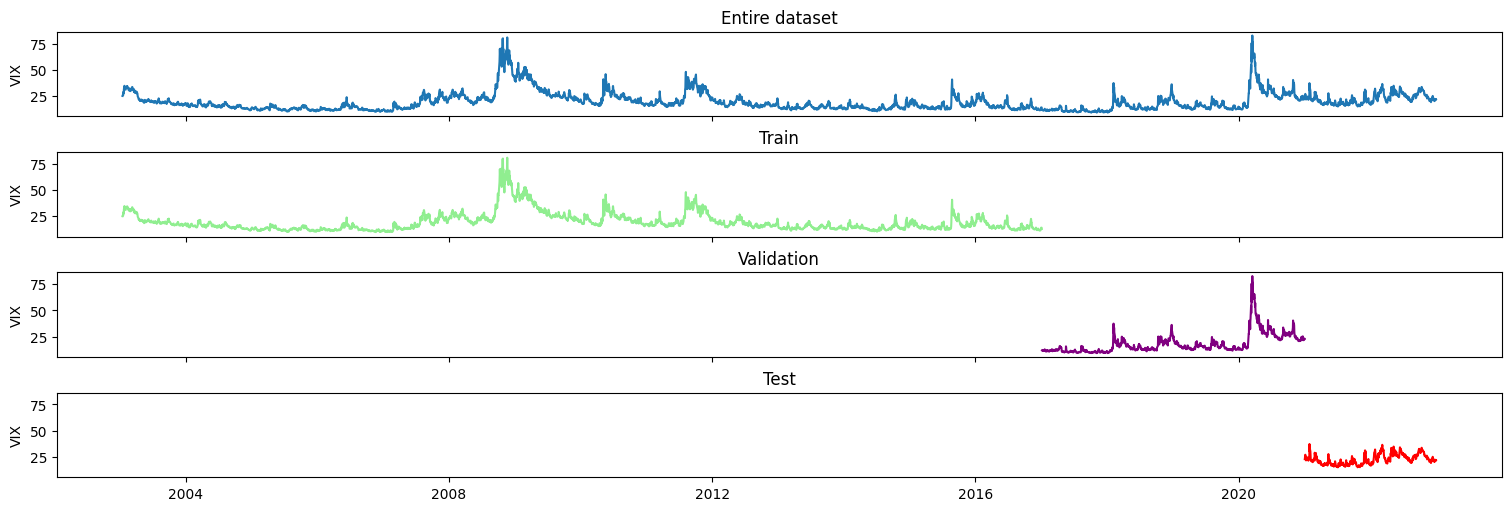

In [72]:
fig, ax = plt.subplots(4, 1, figsize=(15, 5), constrained_layout=True, sharey=True, sharex=True)
sns.lineplot(df.VIX, ax=ax[0])
ax[0].set_title("Entire dataset")
sns.lineplot(train_df.VIX, ax=ax[1], color="lightgreen")
ax[1].set_title("Train")
sns.lineplot(val_df.VIX, ax=ax[2], color="purple")
ax[2].set_title("Validation")
sns.lineplot(test_df.VIX, ax=ax[3], color="red")
ax[3].set_title("Test")

Alternative view using one plot

# Choosing train/val/test/split

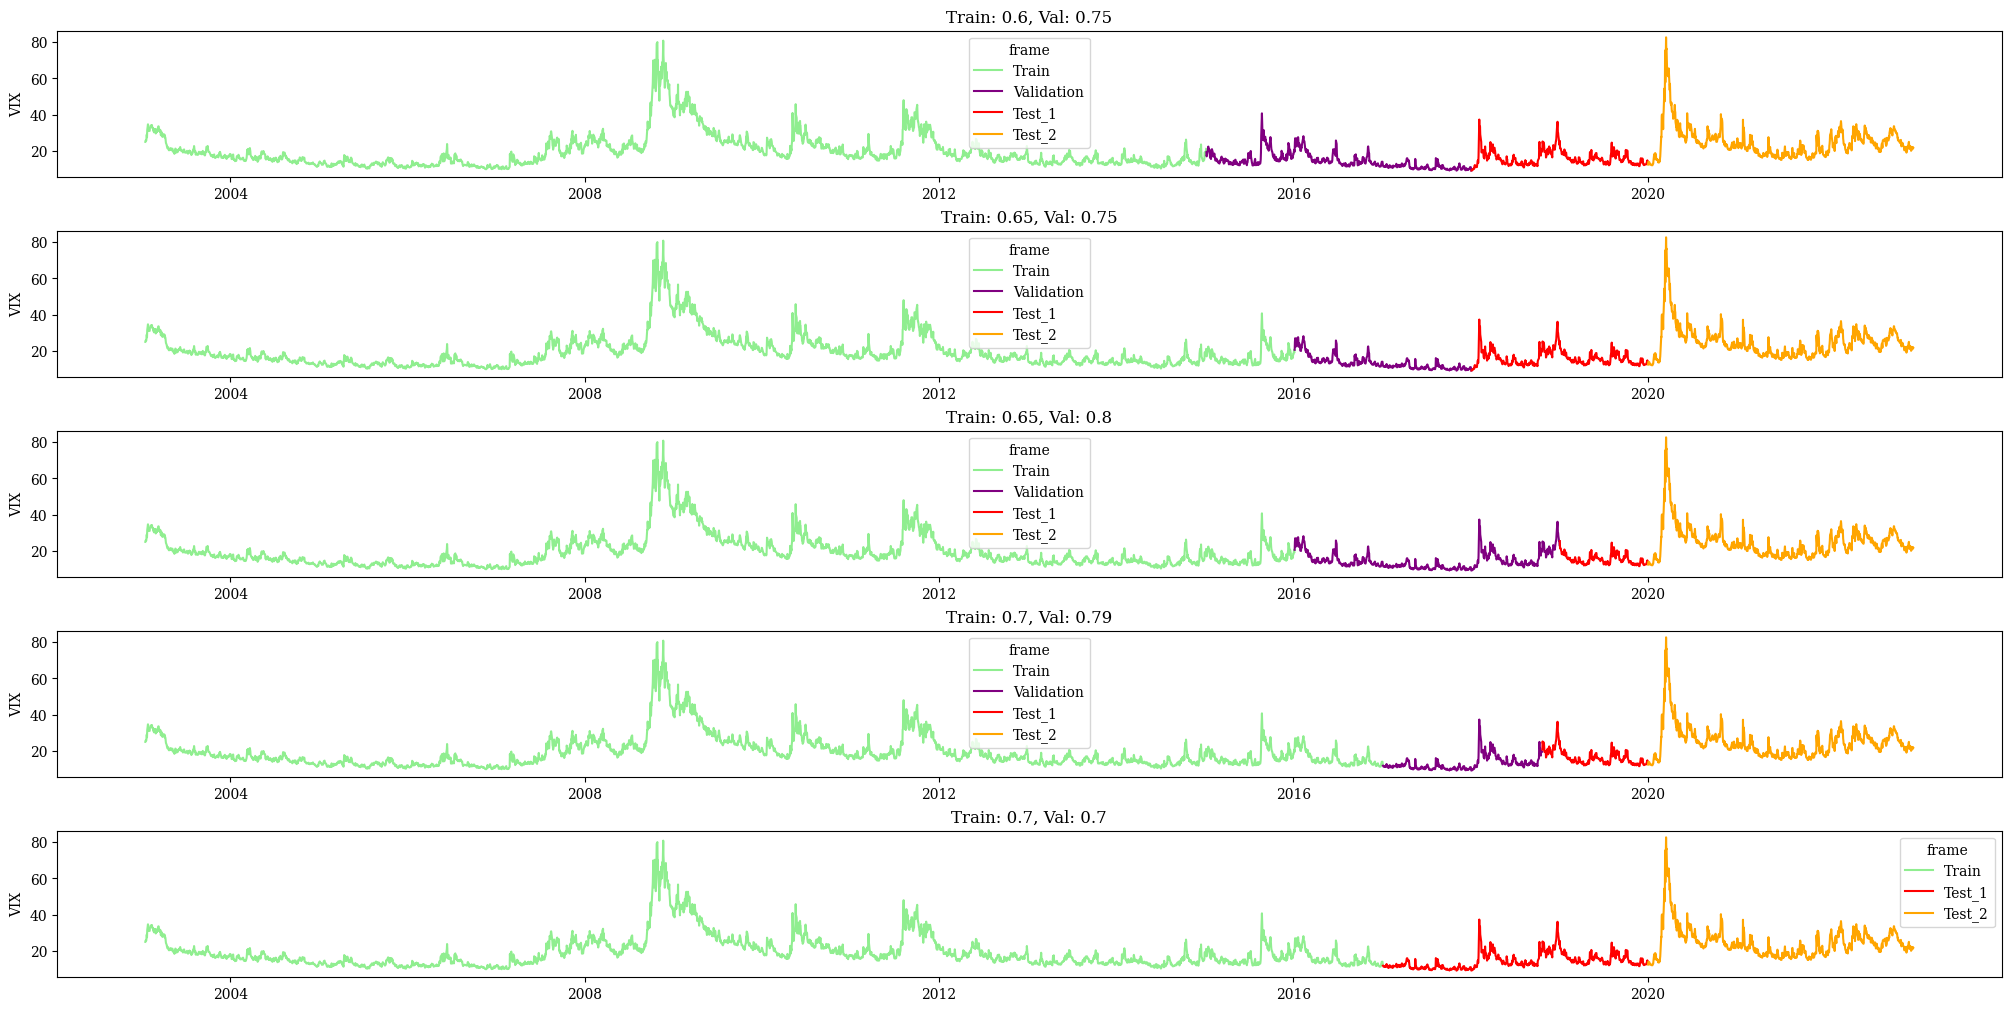

In [649]:
inds = [(0.6, 0.75), (0.65, 0.75), (0.65, 0.8), (0.7, 0.79), (0.70, 0.70)]
fig, axs = plt.subplots(len(inds), 1, figsize=(20, 10), constrained_layout=True)
for ax, ind in zip(axs.ravel(), inds):
    temp = df.VIX.copy().to_frame()
    temp["frame"] = ""
    train_ind = int(n*ind[0])
    val_ind = int(n*ind[1])
    temp.iloc[:train_ind, 1] = "Train"
    temp.iloc[train_ind:val_ind, 1] = "Validation"
    temp.iloc[val_ind:, 1] = "Test_1"
    temp.loc[temp.index > "2020", "frame"] = "Test_2"
    palette = {"Train":"lightgreen", "Validation":"purple", "Test_1":"red", "Test_2":"orange"}
    #fig, ax = plt.subplots(figsize=(20,5))
    ax.set_title(f"Train: {ind[0]}, Val: {ind[1]}")
    sns.lineplot(temp, x=temp.index, y="VIX", hue="frame", palette=palette, ax=ax)
    del temp

In [651]:
print(f'{(df.index >= "2020").argmax() - train_ind}')
df.loc[df.index > "2020"].shape

780


(782, 47)

As can be seen, the test period covers different periods of volatility. Thus, might be intereseting to divide into folds or periods to compare performance. Further, the test set is very small and does not cover a substantially meaningful period. Should maybe be pre- and post-covid.

# Fold Creation and Visualization

### Create windows
Uses `WindowGenerator` to create a window object. Then, get `X_train` and `y_train` as numpy arrays

In [14]:
sys.path.append("../windowing_and_cv")

In [15]:
from windowing_and_cv.tscv_sliding import TimeSeriesSplitSliding
from window_generator import WindowGenerator

In [16]:
from sklearn.model_selection import TimeSeriesSplit as tsp

Create 5 folds with a 75/25 (3:1) split ratio

In [45]:
input_width = 5
w = WindowGenerator(
    input_width=input_width, label_width=1, shift=1, label_columns=['VIX'], 
    train_df=train_df, val_df=val_df, test_df=test_df)
w

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['VIX']

In [46]:
train = w.train

x_train = np.concatenate([x for x, y in train], axis = 0)
y_train = np.concatenate([y for x, y in train], axis = 0)


In [47]:
x_train.shape

(3639, 5, 47)

In [48]:
x_train = x_train.reshape((len(x_train), -1))
x_train[0]

array([ 2.5010000e+01,  2.9200001e+00,  3.2900000e+00,  4.0999999e+00,
        1.1003000e+02,  7.4279999e+01,  2.5100000e+00,  9.3000001e-01,
        6.0300002e+00,  4.3499999e+00,  1.7400000e+00,  5.1599998e+00,
        1.7100000e+00,  2.3099999e+00,  1.4000000e+00,  1.7900000e+00,
        1.2400000e+00,  6.9563305e-01,  6.9331449e-01,  1.0100000e+00,
       -3.4000000e-01,  2.0000000e-01,  1.9000000e-01,  1.0400000e+00,
        1.1700000e+00,  1.1500000e+00,  6.9499731e-01,  2.9170001e-01,
        4.1670001e-01,  2.9170001e-01,  4.0992501e-01,  0.0000000e+00,
        1.0000000e+00,  2.4862000e+01,  2.4881001e+01,  2.4981533e+01,
        2.4934141e+01,  7.5999999e-01, -3.8000000e-01,  6.5702477e+01,
        4.6387833e+01,  2.5768797e+01,  2.3955204e+01,  2.5762083e+01,
        2.3999918e+01,  3.7367073e+01,  3.7367073e+01,  2.5700001e+01,
        2.8699999e+00,  3.2900000e+00,  4.0500002e+00,  3.3840000e+01,
        1.7767999e+02,  2.5300000e+00,  9.2000002e-01,  5.9899998e+00,
      

In [49]:
y_train = y_train.reshape((-1, ))
y_train.shape

(3639,)

Need to store label indices

In [50]:
cols = df.columns
flat_cols = []

for i in range(w.input_width, 0, -1):
    lag = f'_Lag_{i}'
    for col in cols:
        flat_cols.append(f'{col}{lag}')

flat_column_indices = {name: i for i, name in enumerate(flat_cols)}

In [51]:
x_train.shape

(3639, 235)

### Create folds
Create an instance of the `TimeSeriesSplitSliding` class, allowing for creation of folds

In [52]:
n_splits = 5
train_splits = 3
test_splits = 1
tscv = TimeSeriesSplitSliding(n_splits=n_splits, train_splits=train_splits,
                                  test_splits=test_splits, fixed_length=True)

### Visualize folds

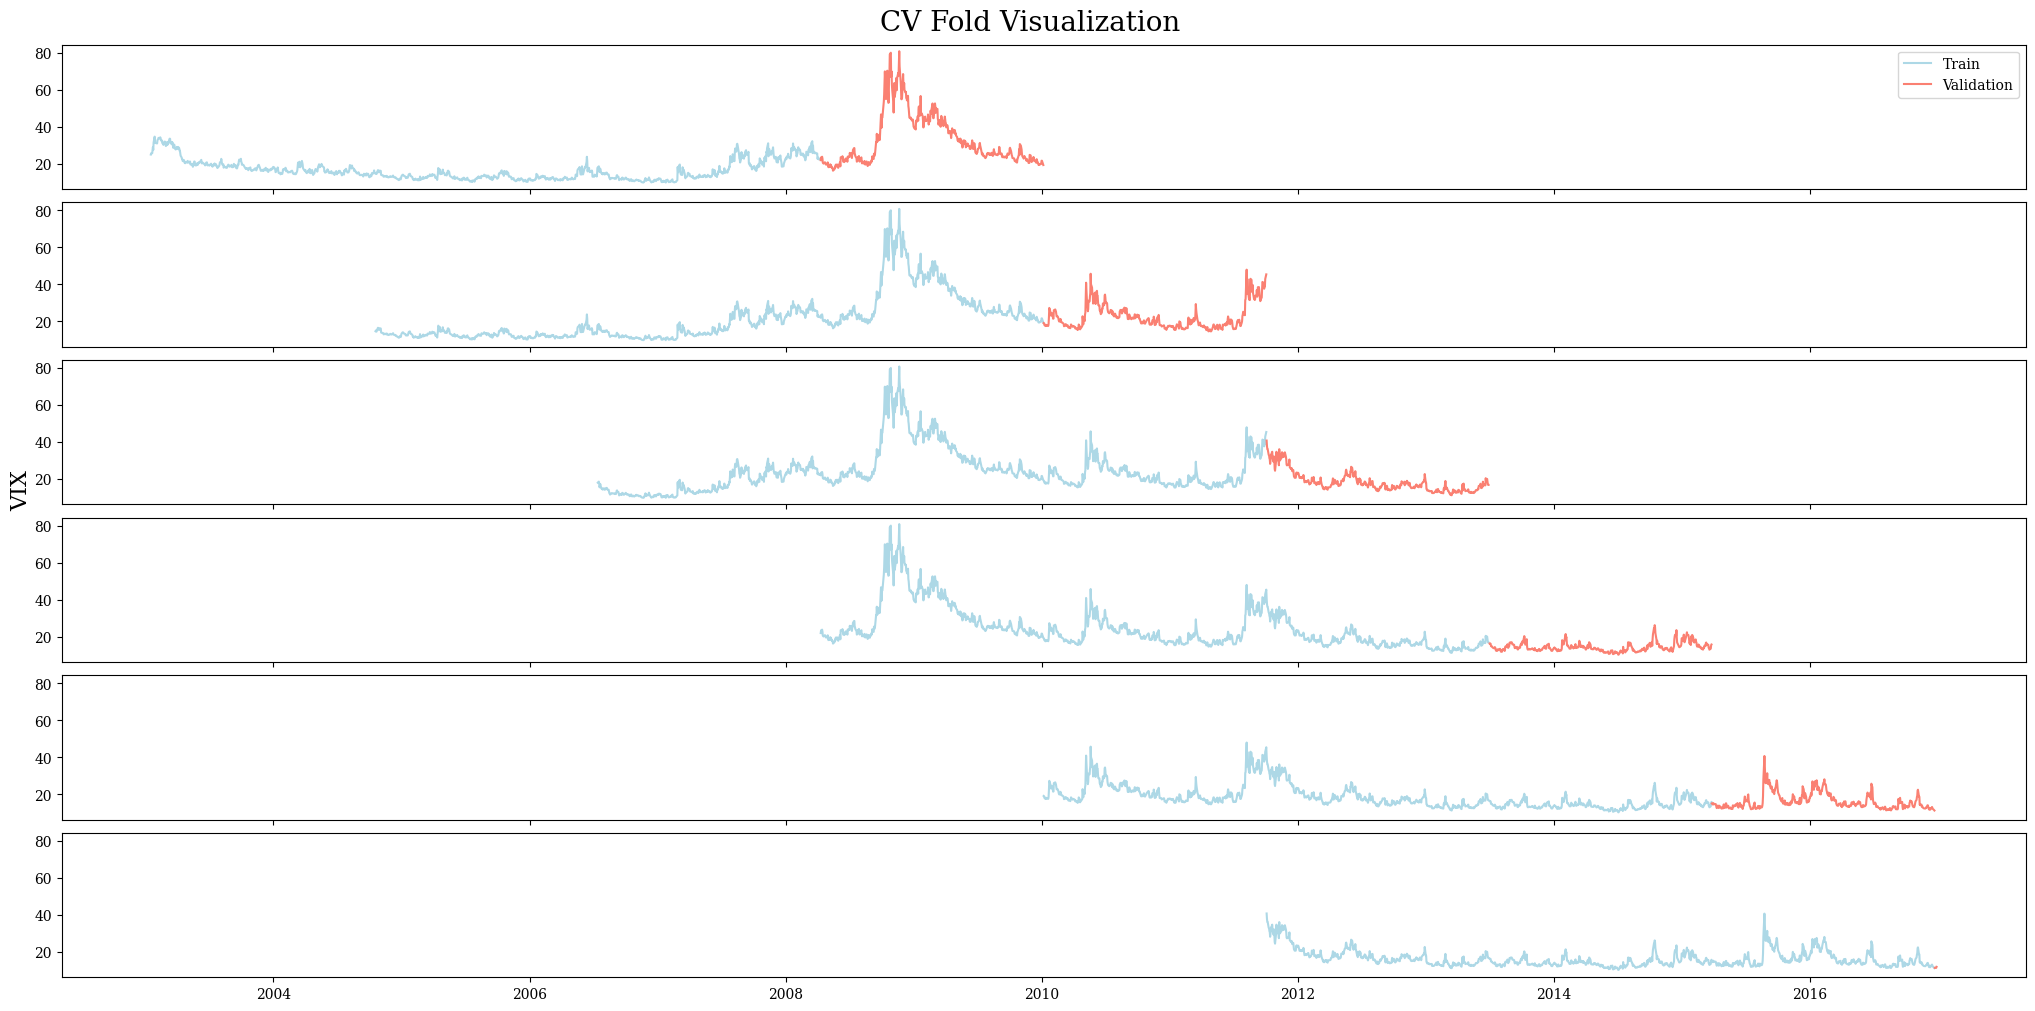

In [53]:
folds = tscv.split(x_train, y_train)
fig, axs = plt.subplots(6, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True)
i = 0
for fold, ax in zip(folds, axs.ravel()):
    #if i > 4:
    #    break
    train = train_df.iloc[fold[0]]
    test = train_df.iloc[fold[1]]
    sns.lineplot(train.VIX, color="lightblue", ax=ax, label="Train")
    sns.lineplot(test.VIX, color="salmon", ax=ax, label="Validation")
    ax.set_ylabel(None)
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    if i > 0:
        ax.get_legend().remove()
    i += 1
fig.text(-0.01, 0.5, "VIX", rotation=90, fontsize=16)
fig.suptitle("CV Fold Visualization", fontsize=20);

### NOTE: CAN SIMPLIFY FOLD CREATION

Can simplify time series window quite a lot, using the following procedure with default sklearn `TimeSeriesSplit`:
```Python
tot_split = n_samples // (n_splits + 1 + train_splits + test_splits)
m_train = tot_split * train_splits
m_test = tot_split * test_splits
tp = TimeSeriesSplit(n_splits=5, max_train_size=m_train, test_size=m_test)
```
Demo:

In [56]:
n_samples = len(train_df)
tot_split = n_samples // (n_splits + 1 + train_splits + test_splits - 2)
m_train = tot_split * train_splits
m_test = tot_split * test_splits
tp = tsp(n_splits=5, max_train_size=m_train, test_size=m_test, )
print(tot_split)
print(m_train)
print(m_test)
print(f"Percentage: {m_test/m_train:.1%}")

455
1365
455
Percentage: 33.3%


In [57]:
for i, fo in enumerate(tp.split(x_train, y_train)):
    print(f"Iteration: {i}")
    xx = fo[0]
    yy = fo[1]
    print(f"Train start: {xx[0]}")
    print(f"Train end/ Test start: {xx[-1]}")
    print(f"Test end: {yy[-1]}")
    print()
    print(f"Train size: {len(xx)}")
    print(f"Test size: {len(yy)}")
    print("-"*20)

Iteration: 0
Train start: 0
Train end/ Test start: 1363
Test end: 1818

Train size: 1364
Test size: 455
--------------------
Iteration: 1
Train start: 454
Train end/ Test start: 1818
Test end: 2273

Train size: 1365
Test size: 455
--------------------
Iteration: 2
Train start: 909
Train end/ Test start: 2273
Test end: 2728

Train size: 1365
Test size: 455
--------------------
Iteration: 3
Train start: 1364
Train end/ Test start: 2728
Test end: 3183

Train size: 1365
Test size: 455
--------------------
Iteration: 4
Train start: 1819
Train end/ Test start: 3183
Test end: 3638

Train size: 1365
Test size: 455
--------------------


### Visualization comparison

Train start: 2003-01-16	Train end: 2003-01-16	Train size: 1364
Test start: 2008-04-09	Test end: 2010-01-05	Test size: 455
Train start: 2004-10-13	Train end: 2004-10-13	Train size: 1365
Test start: 2010-01-06	Test end: 2011-10-04	Test size: 455
Train start: 2006-07-12	Train end: 2006-07-12	Train size: 1365
Test start: 2011-10-05	Test end: 2013-07-02	Test size: 455
Train start: 2008-04-09	Train end: 2008-04-09	Train size: 1365
Test start: 2013-07-03	Test end: 2015-03-31	Test size: 455
Train start: 2010-01-06	Train end: 2010-01-06	Train size: 1365
Test start: 2015-04-01	Test end: 2016-12-27	Test size: 455
2017-01-03


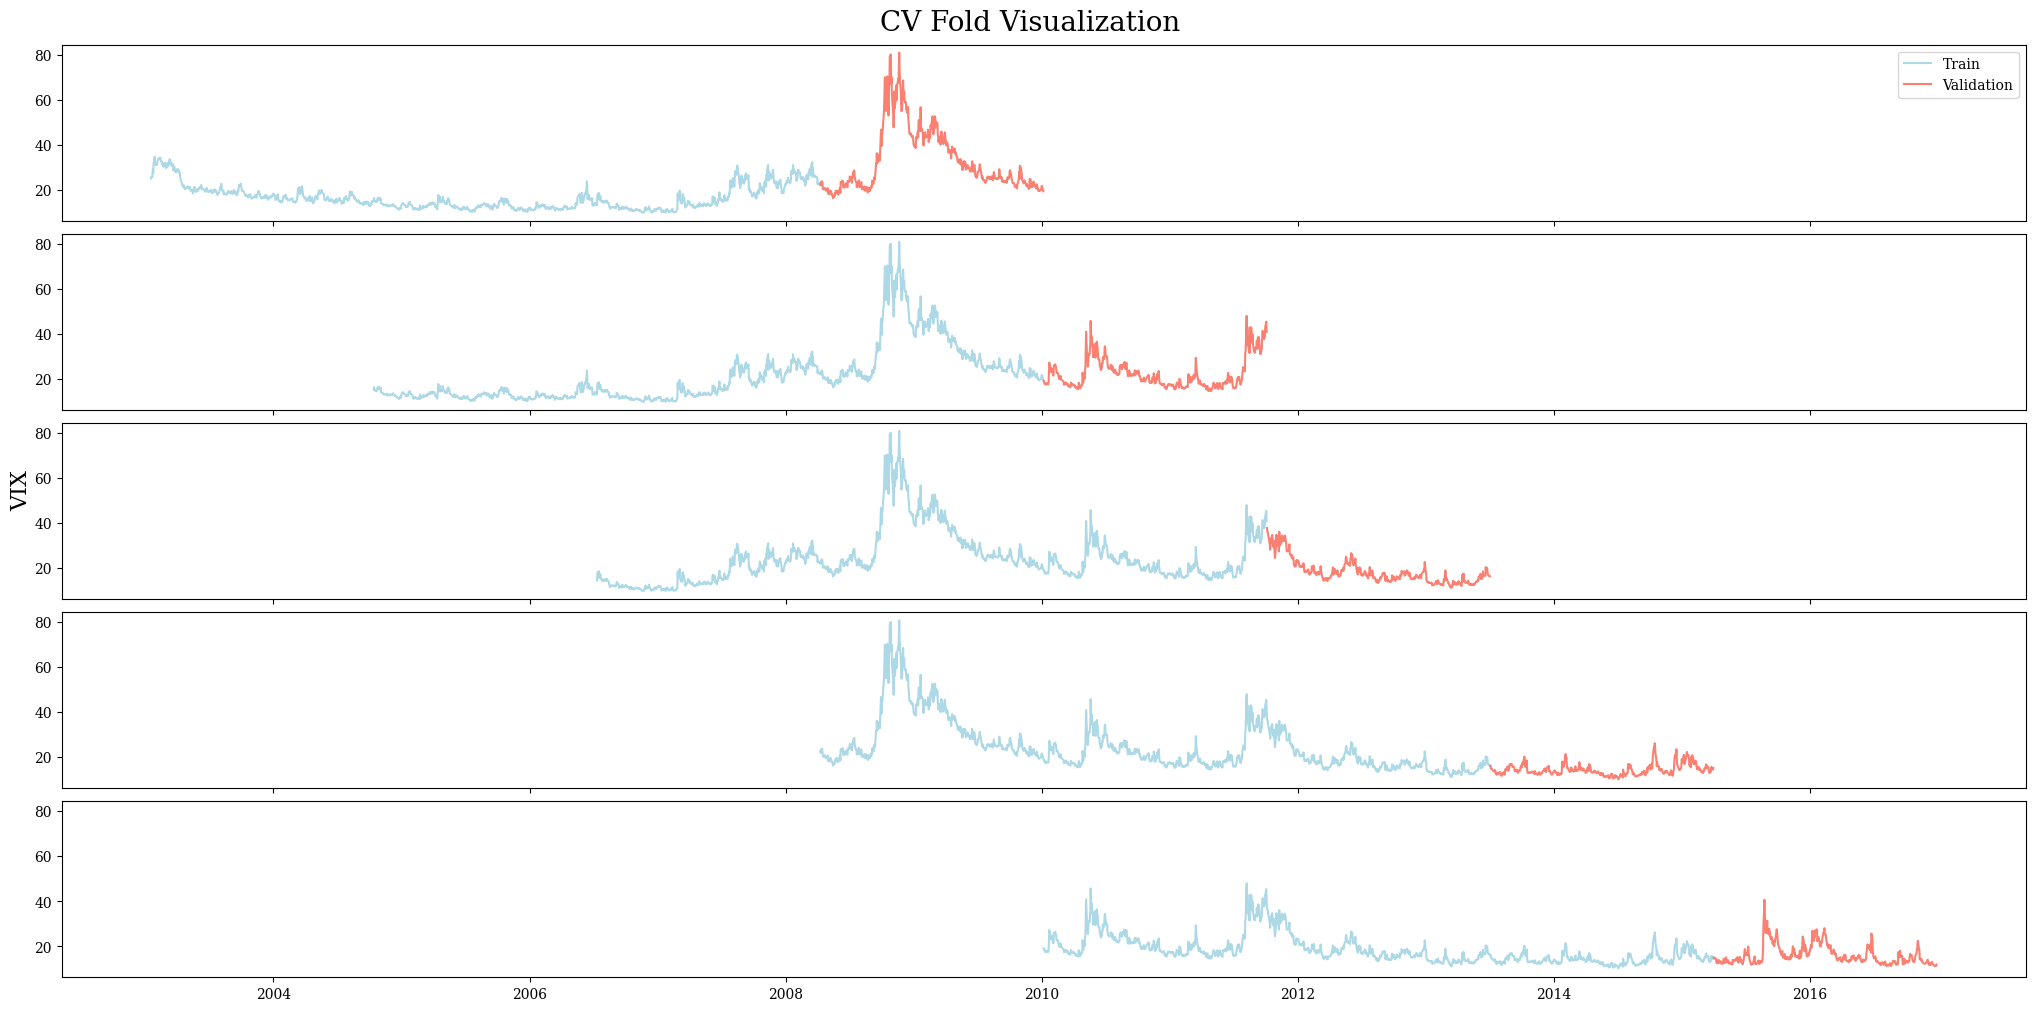

In [58]:
folds = tp.split(x_train, y_train)
fig, axs = plt.subplots(5, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True)
i = 0
i_train = 0
i_test = 0
for fold, ax in zip(folds, axs.ravel()):
    #if i > 4:
    #    break
    train = train_df.iloc[fold[0]]
    test = train_df.iloc[fold[1]]
    print(f"Train start: {train.index[0].date()}\tTrain end: {train.index[0].date()}\tTrain size: {len(train)}")
    print(f"Test start: {test.index[0].date()}\tTest end: {test.index[-1].date()}\tTest size: {len(test)}")
    sns.lineplot(train.VIX, color="lightblue", ax=ax, label="Train")
    sns.lineplot(test.VIX, color="salmon", ax=ax, label="Validation")
    ax.set_ylabel(None)
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    i_train += len(train)
    if i > 0:
        ax.get_legend().remove()
    i += 1
print(train_df.index[-1].date())
fig.text(-0.01, 0.5, "VIX", rotation=90, fontsize=16)
fig.suptitle("CV Fold Visualization", fontsize=20);

# Selection

In [7]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

### Heatmap visualization for correlation of predictors

<AxesSubplot: >

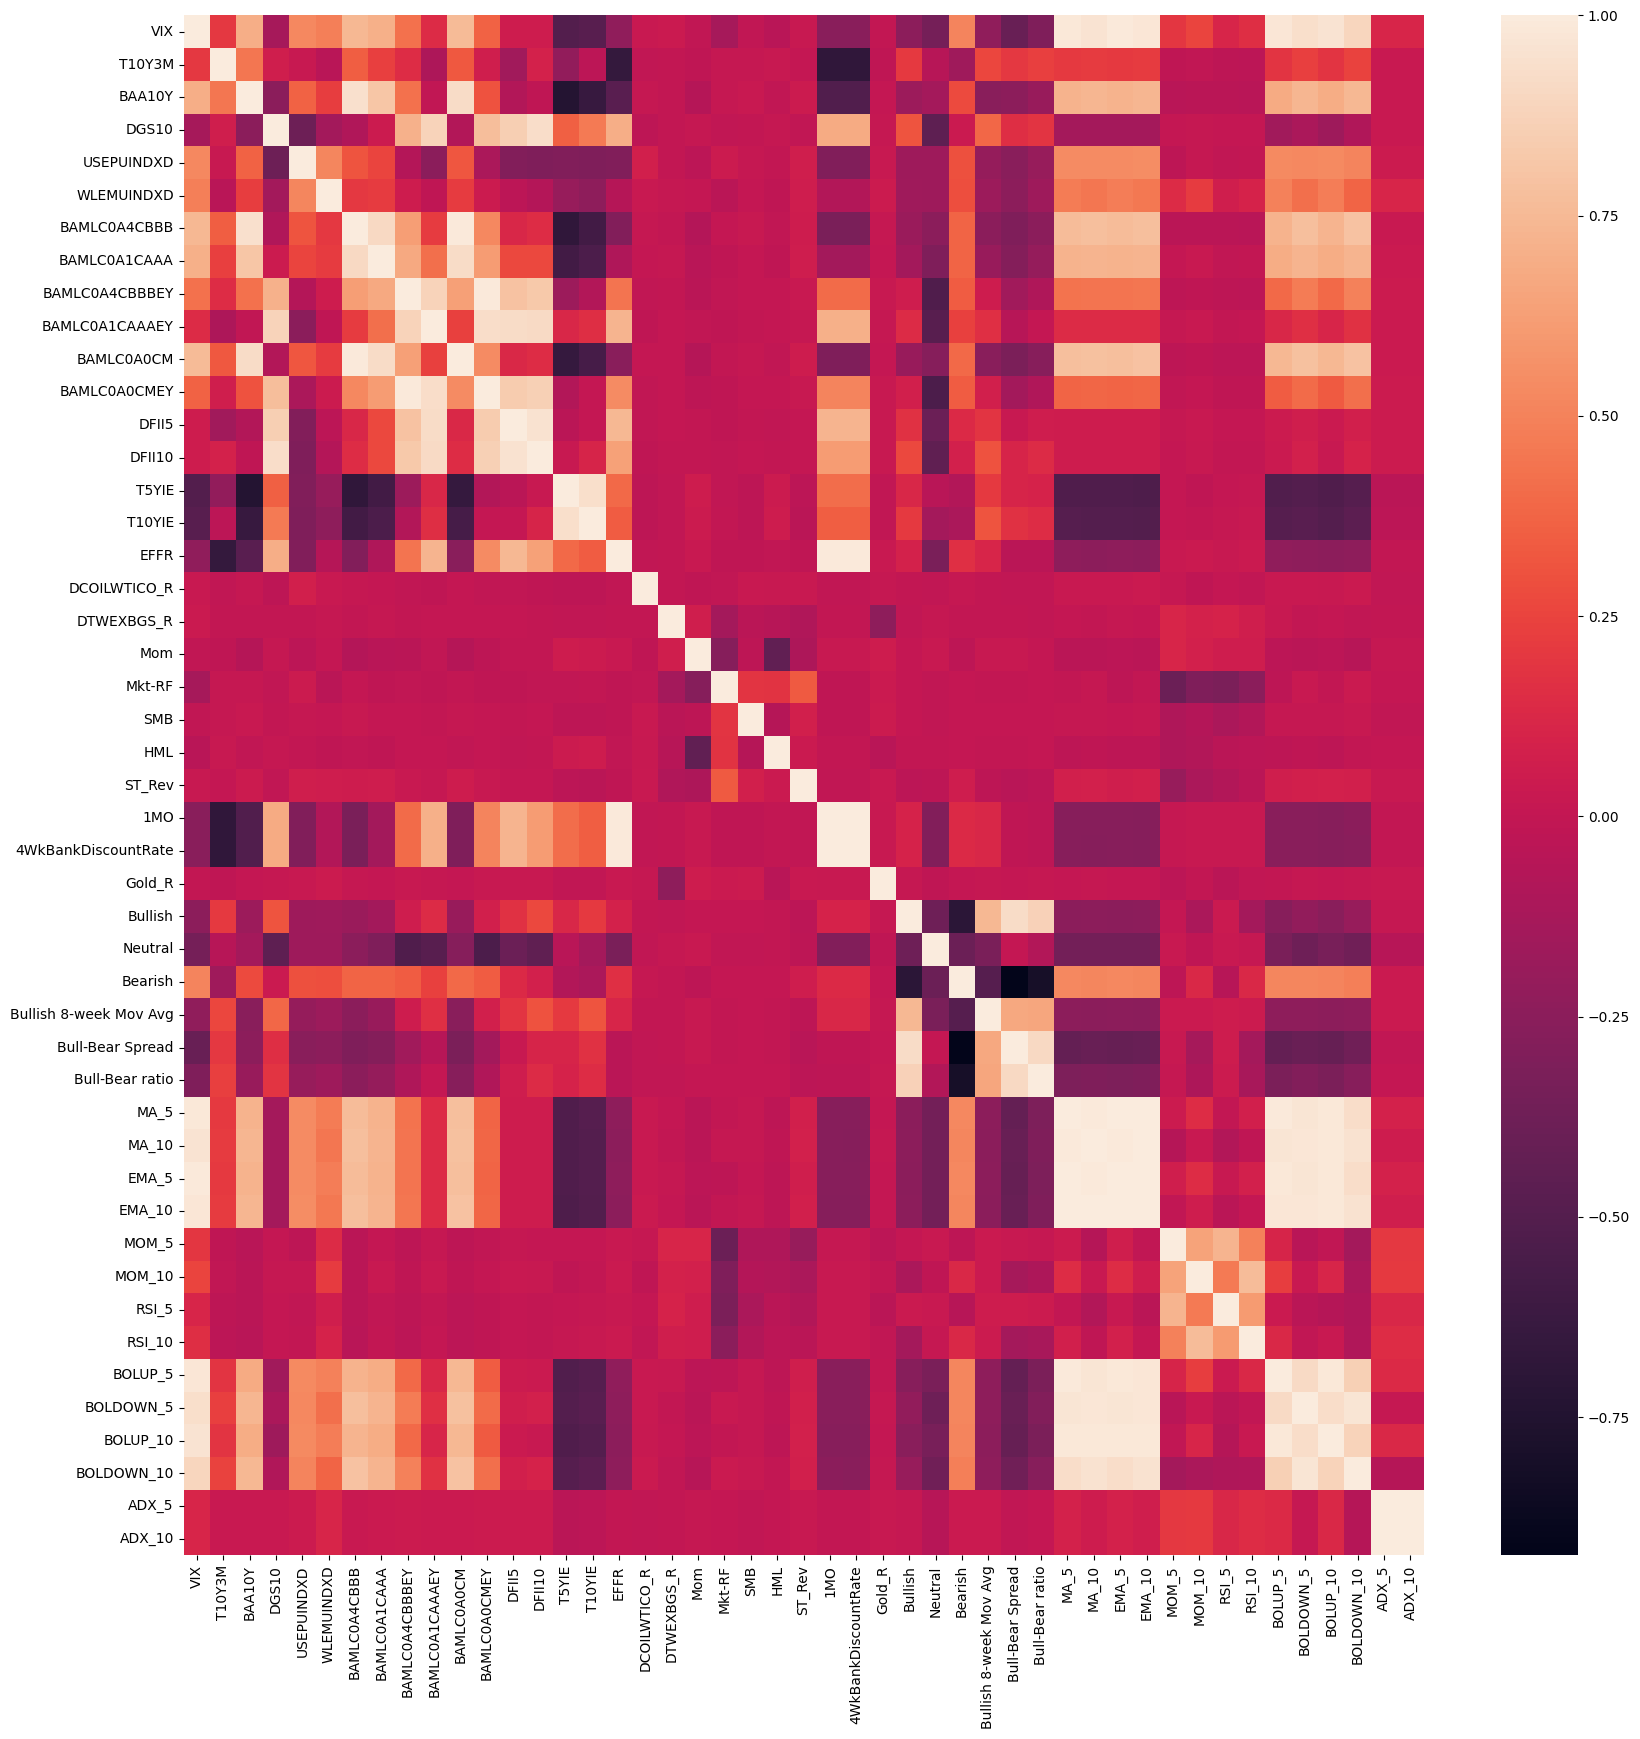

In [47]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(), ax=ax)

In [59]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [60]:
from sklearn.pipeline import Pipeline

In [61]:
from sklearn.model_selection import GridSearchCV

## Standardizing within each fold

Create window

In [429]:
input_width = 5
w = WindowGenerator(
    input_width=input_width, label_width=1, shift=1, label_columns=['VIX'], 
    train_df=train_df, val_df=val_df, test_df=test_df
)
w

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['VIX']

Get `X` and `y` as numpy array

In [431]:
train = w.train
x_train = np.concatenate([x for x, y in train], axis = 0)
y_train = np.concatenate([y for x, y in train], axis = 0)

Reshape `X` into `(num_days, num_lags*num_features)`-array

In [432]:
x_train = x_train.reshape(len(x_train), -1)

Reshape `y` into `(num_days,)`-array

In [433]:
y_train = y_train.reshape((-1, ))
y_train.shape

(3639,)

Create `TimeSeriesSplit` class

In [434]:
n_splits = 5
train_splits = 3
test_splits = 1

tot_split = n_samples // (n_splits + 1 + train_splits + test_splits - 2)
m_train = tot_split * train_splits
m_test = tot_split * test_splits

tp = TimeSeriesSplit(n_splits=5, max_train_size=m_train, test_size=m_test)

### Using sklearn GridSearchCV

Create a pipeline using a scaler and elastic net

In [157]:
from sklearn.pipeline import Pipeline

In [435]:
pipe = Pipeline([('scaler', MinMaxScaler()), ("elnet", ElasticNet(alpha=1e-5, l1_ratio=0))])

Set up parameter grid for grid search

In [438]:
param_grid = dict(
    elnet__alpha=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
    elnet__l1_ratio=np.arange(0.1, 1, 0.1)
)

Perform search. The below function helps mute `ConvergenceWarning` when `n_jobs` is 1

In [439]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
@ignore_warnings(category=ConvergenceWarning)
def gs(pipe, param_grid, cv, scoring='neg_mean_squared_error', n_jobs=-1):
    search = GridSearchCV(pipe, param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)
    # perform the search
    results = search.fit(x_train, y_train)
    return results

In [441]:
results = gs(pipe, param_grid, cv=tp, scoring='neg_mean_squared_error', n_jobs=1)
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
print("JJ")

/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regul

MSE: -4.205
Config: {'elnet__alpha': 0.01, 'elnet__l1_ratio': 0.9}
JJ


### Manual

#### Setup and performing

Create folds

In [62]:
folds = list(tp.split(x_train, y_train))

Create helper function for iterating over folds

In [63]:
def create_data(fold, train_df:pd.DataFrame, window_generator:WindowGenerator):
    # Get indices
    train_indices, val_indices = fold
    # Get data 
    train = train_df.iloc[train_indices]
    val = train_df.iloc[val_indices]
    # Scale fold
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    # Make dataset using Windowgenerator
    train = window_generator.make_dataset(train)
    val = window_generator.make_dataset(val)

    # Convert to numpy arrays
    train_X = np.concatenate([x for x, y in train], axis=0)
    train_X = train_X.reshape(len(train_X), -1)
    
    train_y = np.concatenate([y for x, y in train], axis=0)
    train_y = train_y.reshape((-1))

    val_X = np.concatenate([x for x, y in val], axis=0)
    val_X = val_X.reshape(len(val_X), -1)
    
    val_y = np.concatenate([y for x, y in val], axis=0)
    val_y = val_y.reshape((-1))
    
    return train_X, train_y, val_X, val_y

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

Create parameter grid

In [470]:
param_grid = dict(
    elnet_alpha=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
    elnet_l1_ratio=np.arange(0, 1, 0.1)
)

Perfor cross validation

In [478]:
# Save error metrics
metrics = {
    "mse":mean_squared_error, "mae": mean_absolute_error, 
    "mape": mean_absolute_percentage_error, "r2":r2_score
}

param_results  = dict()

# Iterate over parameters
for alpha in param_grid["elnet_alpha"]:
    for l1_ratio in param_grid["elnet_l1_ratio"]:
        print(f"Params: {alpha}, {l1_ratio}")
        results = {key:[] for key in metrics.keys()}
        for fold in folds:
            # Create model
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            # Get data                    
            train_X, train_y, val_X, val_y = create_data(fold, train_df, w)
            #print(f"train x: {train_X.shape}\ttrain y: {train_y.shape}")
            #print(f"val x: {val_X.shape}\tval y: {val_y.shape}")
            
            # Fit
            model.fit(train_X, train_y)

            # Predict
            prediction = model.predict(val_X)
            for key, metric in metrics.items():
                score = metric(val_y, prediction)
                results[key].append(score)
                
        # Compute mean for each metric over all folds
        mean_results = {key:[] for key in metrics.keys()}
        for key, metric in results.items():
            mean_score = np.mean(metric)
            mean_results[key] = mean_score
        name = f"alpha: {alpha}, l1_ratio: {l1_ratio}"
        param_results[name] = mean_results

Params: 1e-05, 0.0
Params: 1e-05, 0.1
Params: 1e-05, 0.2
Params: 1e-05, 0.30000000000000004
Params: 1e-05, 0.4
Params: 1e-05, 0.5
Params: 1e-05, 0.6000000000000001
Params: 1e-05, 0.7000000000000001
Params: 1e-05, 0.8
Params: 1e-05, 0.9
Params: 0.0001, 0.0
Params: 0.0001, 0.1
Params: 0.0001, 0.2
Params: 0.0001, 0.30000000000000004
Params: 0.0001, 0.4
Params: 0.0001, 0.5
Params: 0.0001, 0.6000000000000001
Params: 0.0001, 0.7000000000000001
Params: 0.0001, 0.8
Params: 0.0001, 0.9
Params: 0.001, 0.0
Params: 0.001, 0.1
Params: 0.001, 0.2
Params: 0.001, 0.30000000000000004
Params: 0.001, 0.4
Params: 0.001, 0.5
Params: 0.001, 0.6000000000000001
Params: 0.001, 0.7000000000000001
Params: 0.001, 0.8
Params: 0.001, 0.9
Params: 0.01, 0.0
Params: 0.01, 0.1
Params: 0.01, 0.2
Params: 0.01, 0.30000000000000004
Params: 0.01, 0.4
Params: 0.01, 0.5
Params: 0.01, 0.6000000000000001
Params: 0.01, 0.7000000000000001
Params: 0.01, 0.8
Params: 0.01, 0.9
Params: 0.1, 0.0
Params: 0.1, 0.1
Params: 0.1, 0.2
Param

/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 0.0, 0.1


/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 0.0, 0.2


/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 0.0, 0.30000000000000004


/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 0.0, 0.4


/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 0.0, 0.5


/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 0.0, 0.6000000000000001


/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 0.0, 0.7000000000000001


/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 0.0, 0.8


/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 0.0, 0.9


/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/var/folders/s0/sx8kfxjn2k1g0_qh0b73f0p40000gn/T/ipykernel_81529/2351026723.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

Params: 1.0, 0.0
Params: 1.0, 0.1
Params: 1.0, 0.2
Params: 1.0, 0.30000000000000004
Params: 1.0, 0.4
Params: 1.0, 0.5
Params: 1.0, 0.6000000000000001
Params: 1.0, 0.7000000000000001
Params: 1.0, 0.8
Params: 1.0, 0.9
Params: 10.0, 0.0
Params: 10.0, 0.1
Params: 10.0, 0.2
Params: 10.0, 0.30000000000000004
Params: 10.0, 0.4
Params: 10.0, 0.5
Params: 10.0, 0.6000000000000001
Params: 10.0, 0.7000000000000001
Params: 10.0, 0.8
Params: 10.0, 0.9
Params: 100.0, 0.0
Params: 100.0, 0.1
Params: 100.0, 0.2
Params: 100.0, 0.30000000000000004
Params: 100.0, 0.4
Params: 100.0, 0.5
Params: 100.0, 0.6000000000000001
Params: 100.0, 0.7000000000000001
Params: 100.0, 0.8
Params: 100.0, 0.9


In [484]:
min_vals = {key: (1000, "None") for key in metrics.keys()}
for key, items in param_results.items():
    for metric, score in items.items():
        cur_min = min_vals[metric][0]
        if score < cur_min:
            min_vals[metric] = (score, key)

#### Results

In [486]:
min_vals

{'mse': (0.0035683315, 'alpha: 0.0001, l1_ratio: 0.9'),
 'mae': (0.029772257, 'alpha: 0.0001, l1_ratio: 0.9'),
 'mape': (0.21035294, 'alpha: 0.0001, l1_ratio: 0.9'),
 'r2': (-3.872401975138323, 'alpha: 0.1, l1_ratio: 0.5')}

## With standardizing entire dataset 

### Scale

In [9]:
scaler = MinMaxScaler()

Use same proportion as for folds, ie, 75% train vs 25% val

In [11]:
split = int(len(train_df)*0.75)
temp_train = train_df.iloc[:split].copy()
temp_val = train_df.iloc[split:].copy()

In [12]:
# With own defined split
temp_train = pd.DataFrame(
    scaler.fit_transform(temp_train),
    index=temp_train.index, columns=temp_train.columns
)
temp_val = pd.DataFrame(
    scaler.transform(temp_val),
    index=temp_val.index, columns=temp_val.columns
)

### Create windows

In [17]:
input_width = 5
window = WindowGenerator(
    input_width=input_width, label_width=1, shift=1, label_columns=['VIX'], 
    train_df=temp_train, val_df=temp_val,
)
window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['VIX']

Make dataset using Windowgenerator

In [18]:
# Make dataset using Windowgenerator
train = window.train
val = window.val

# Convert to numpy arrays
train_X = np.concatenate([x for x, y in train], axis=0)
train_X = train_X.reshape(len(train_X), -1)

train_y = np.concatenate([y for x, y in train], axis=0)
train_y = train_y.reshape((-1))

val_X = np.concatenate([x for x, y in val], axis=0)
val_X = val_X.reshape(len(val_X), -1)

val_y = np.concatenate([y for x, y in val], axis=0)
val_y = val_y.reshape((-1))

### Use elastic net parameters from cross val

In [507]:
min_vals

{'mse': (0.0035683315, 'alpha: 0.0001, l1_ratio: 0.9'),
 'mae': (0.029772257, 'alpha: 0.0001, l1_ratio: 0.9'),
 'mape': (0.21035294, 'alpha: 0.0001, l1_ratio: 0.9'),
 'r2': (-3.872401975138323, 'alpha: 0.1, l1_ratio: 0.5')}

In [29]:
model = ElasticNet(alpha=0.0001, l1_ratio=0.9)

In [30]:
model.fit(train_X, train_y)
prediction = model.predict(val_X)

/Users/hakonisern/PycharmProjects/Master/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.309e-03, tolerance: 5.082e-03
  model = cd_fast.enet_coordinate_descent(


In [31]:
metrics = {
    "mse":mean_squared_error, "mae": mean_absolute_error, 
    "mape": mean_absolute_percentage_error, "r2":r2_score
}

In [32]:
for key, metric in metrics.items():
    print(key)
    print(metric(val_y, prediction))
    print("-"*20)

mse
0.0003992635
--------------------
mae
0.013167706
--------------------
mape
0.19080332
--------------------
r2
0.8525073831083467
--------------------


### Residual analys

In [594]:
from scipy.stats import norm

In [596]:
from statsmodels.api import qqplot

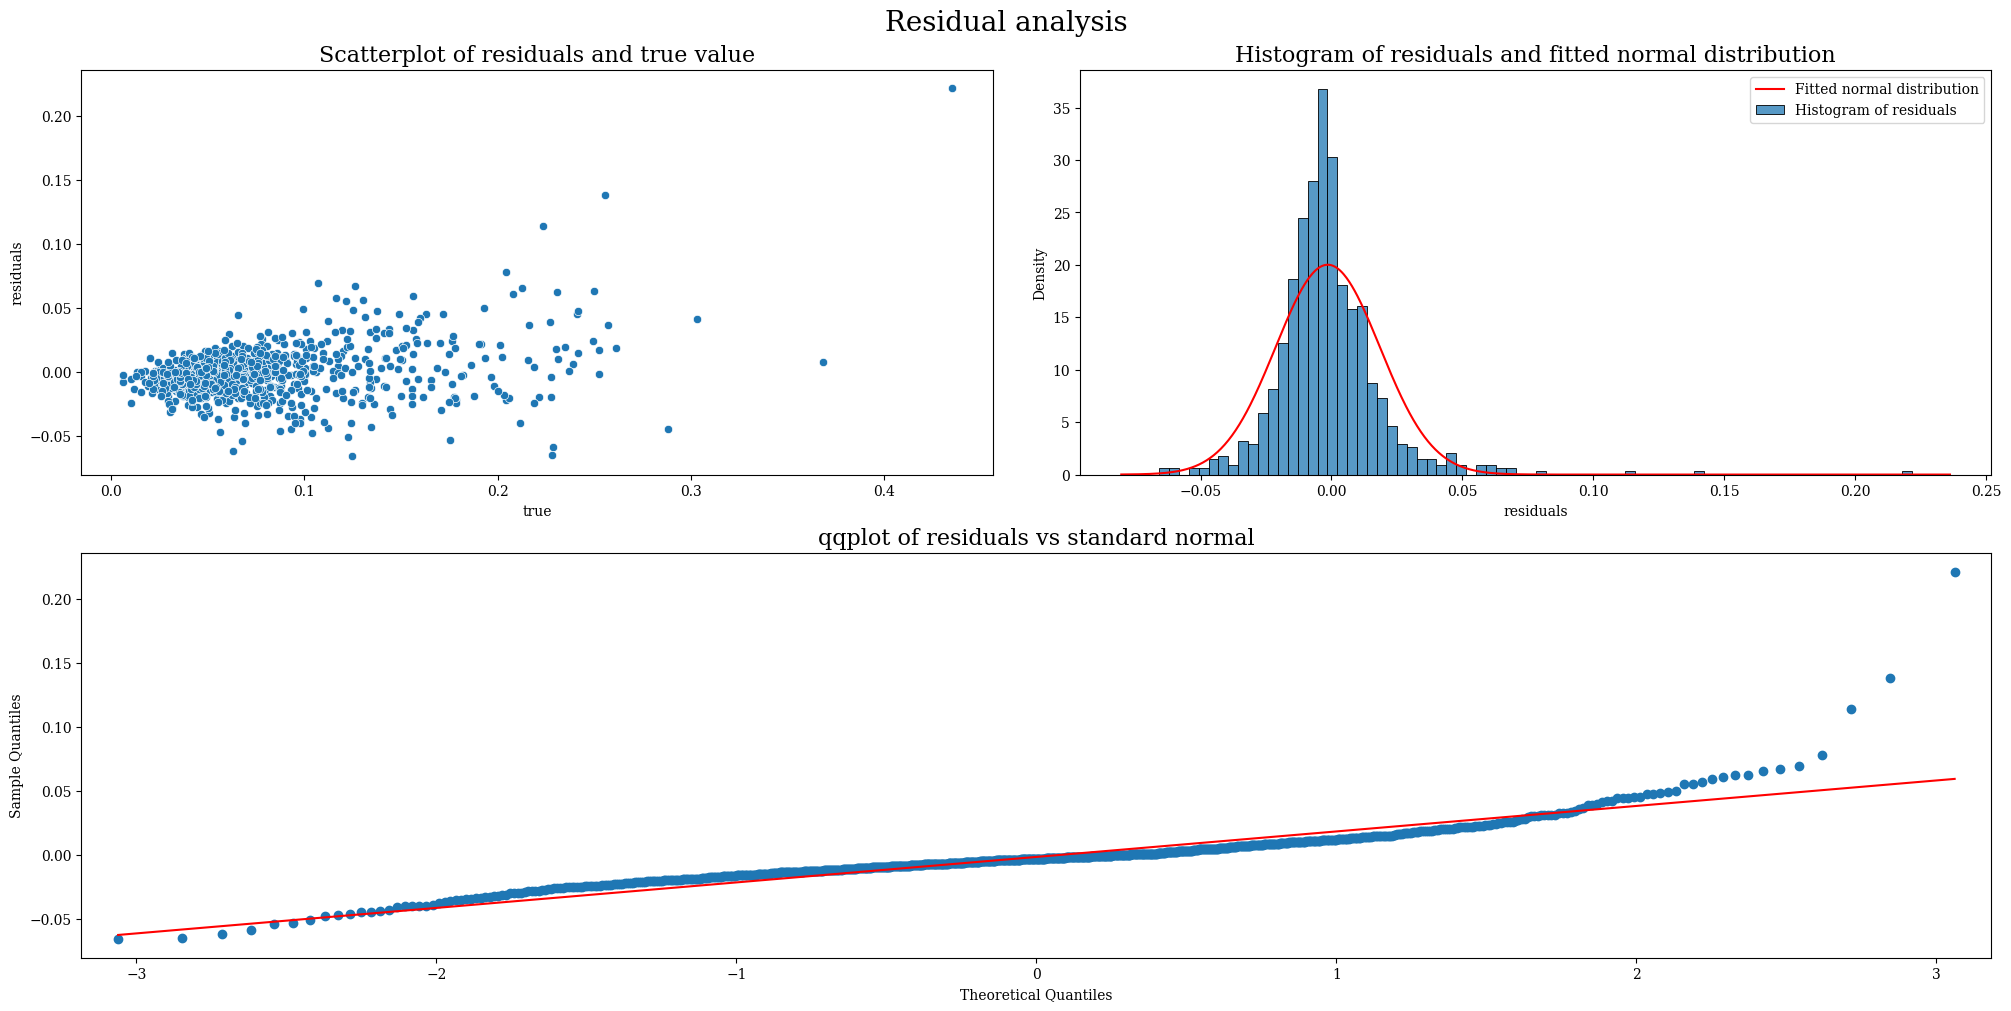

In [603]:
#let's look at the residuals as well:
#matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
fig, axs = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)
preds = pd.DataFrame({"preds":prediction, "true":val_y})
preds["residuals"] = preds["true"] - preds["preds"]

sns.scatterplot(preds, x="true", y="residuals", ax=axs[0, 0])
axs[0,0].set_title("Scatterplot of residuals and true value", fontsize=16)

sns.histplot(preds.residuals, ax=axs[0,1], stat="density", label="Histogram of residuals")
mu, std = norm.fit(preds.residuals, loc=0, scale=1)
x0, x1 = axs[0, 1].get_xlim()  # axes for p1 is required to determine x_pdf
x_pdf = np.linspace(x0, x1, len(preds))
y_pdf = norm.pdf(x_pdf, loc=mu, scale=std)
sns.lineplot(x=x_pdf, y=y_pdf, ax=axs[0,1], color="red", label="Fitted normal distribution")
axs[0, 1].set_title("Histogram of residuals and fitted normal distribution", fontsize=16)
fig.suptitle("Residual analysis", fontsize=20)


gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])

qqplot(preds.residuals, line="s", ax=axbig)
axbig.set_title("qqplot of residuals vs standard normal", fontsize=16);

### Coefficients

Create `pd.Series` over column and corresponding coefficient value

In [34]:
cols = df.columns
flat_cols = []

for i in range(window.input_width, 0, -1):
    lag = f'_Lag_{i}'
    for col in cols:
        flat_cols.append(f'{col}{lag}')

coeff_value = pd.Series({name: model.coef_[i] for i, name in enumerate(flat_cols)})

Display all coefficients different from zero

In [35]:
coeff_value[coeff_value != 0].index.str[:-6].unique()

Index(['T10Y3M', 'USEPUINDXD', 'DFII10', 'ADX_5', 'ADX_10', 'WLEMUINDXD',
       'SMB', 'MOM_10', 'RSI_5', 'BOLUP_10', 'VIX', 'BAMLC0A1CAAA',
       'BAMLC0A0CM', 'ST_Rev', 'Neutral', 'Bearish', 'MA_5', 'MA_10', 'EMA_5',
       'RSI_10', 'BOLDOWN_5'],
      dtype='object')

All coefficients and values

In [36]:
coeff_value[coeff_value != 0]

T10Y3M_Lag_5          0.004809
USEPUINDXD_Lag_5      0.002553
DFII10_Lag_5          0.006576
USEPUINDXD_Lag_4      0.015187
ADX_5_Lag_3          -0.002508
ADX_10_Lag_3         -0.000707
WLEMUINDXD_Lag_2      0.004275
SMB_Lag_2            -0.005298
MOM_10_Lag_2          0.005568
RSI_5_Lag_2           0.001127
BOLUP_10_Lag_2        0.093326
VIX_Lag_1             0.710970
BAMLC0A1CAAA_Lag_1    0.005200
BAMLC0A0CM_Lag_1      0.021990
SMB_Lag_1            -0.010769
ST_Rev_Lag_1         -0.007789
Neutral_Lag_1        -0.000003
Bearish_Lag_1         0.000609
MA_5_Lag_1            0.045531
MA_10_Lag_1           0.024674
EMA_5_Lag_1           0.029454
RSI_5_Lag_1           0.007615
RSI_10_Lag_1          0.002764
BOLDOWN_5_Lag_1       0.005174
dtype: float32

#### Most positive

In [37]:
coeff_value[coeff_value > 0].sort_values(ascending=False)

VIX_Lag_1             0.710970
BOLUP_10_Lag_2        0.093326
MA_5_Lag_1            0.045531
EMA_5_Lag_1           0.029454
MA_10_Lag_1           0.024674
BAMLC0A0CM_Lag_1      0.021990
USEPUINDXD_Lag_4      0.015187
RSI_5_Lag_1           0.007615
DFII10_Lag_5          0.006576
MOM_10_Lag_2          0.005568
BAMLC0A1CAAA_Lag_1    0.005200
BOLDOWN_5_Lag_1       0.005174
T10Y3M_Lag_5          0.004809
WLEMUINDXD_Lag_2      0.004275
RSI_10_Lag_1          0.002764
USEPUINDXD_Lag_5      0.002553
RSI_5_Lag_2           0.001127
Bearish_Lag_1         0.000609
dtype: float32

#### Most negative

In [38]:
coeff_value[coeff_value < 0].sort_values()

SMB_Lag_1       -0.010769
ST_Rev_Lag_1    -0.007789
SMB_Lag_2       -0.005298
ADX_5_Lag_3     -0.002508
ADX_10_Lag_3    -0.000707
Neutral_Lag_1   -0.000003
dtype: float32

In [39]:
model.score(val_X, val_y)

0.8525073831083467

In [42]:
model.get_params()

{'alpha': 0.0001,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.9,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

## Iterative sliding window
Use a window size of *n*, estimate *Elastic net* coefficients. Then slide window forward, re-estimate *Elastic Net*. Continue until end of period

# Interpretation